In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "xgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-29 08:46:04.566861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 08:46:04.651271: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 08:46:05.142663: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_153


In [2]:
# 特徴生成
files = sorted(list(glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")))
f_files = sorted(list(glob("/kaggle/input/heauristic_features/heauristic_features/*.parquet")))
files = [(f, ff) for f, ff in zip(files, f_files)]
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [17:26<00:00,  3.78s/it] 


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,is_sleep_block_rolling_mean_5_shift_-2,is_sleep_block_rolling_mean_5_shift_-25,is_sleep_block_rolling_mean_5_shift_-5,is_sleep_block_rolling_mean_5_shift_-50,is_sleep_block_rolling_mean_5_shift_10,is_sleep_block_rolling_mean_5_shift_2,is_sleep_block_rolling_mean_5_shift_25,is_sleep_block_rolling_mean_5_shift_5,is_sleep_block_rolling_mean_5_shift_50,fold
32,-83.1250,0.432373,0.432373,-6.062500,0.015564,0.001191,0.064697,147.5,0.0,57747.5,...,0.883301,0.0,1.0,0.0,0.399902,0.083313,1.0,0.000000,NaN,2
33,-83.5625,0.067688,0.067688,-7.804688,0.014847,0.000298,0.051178,207.5,0.0,57807.5,...,1.000000,0.0,1.0,0.0,0.199951,0.283447,1.0,0.000000,NaN,2
34,-83.6250,0.067688,0.067688,-5.238281,0.015167,0.000435,0.078796,267.5,0.0,57867.5,...,1.000000,0.0,1.0,0.0,0.000000,0.483398,1.0,0.000000,NaN,2
35,-83.5000,0.114563,0.114563,-9.828125,0.014633,0.000310,0.057922,327.5,0.0,57927.5,...,1.000000,0.0,1.0,0.0,0.000000,0.683105,1.0,0.083313,NaN,2
36,-83.0625,0.072937,0.072937,-13.796875,0.017395,0.007259,0.055939,387.5,0.0,57987.5,...,1.000000,0.0,1.0,0.0,0.000000,0.883301,1.0,0.283447,NaN,2


(993599, 1735)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["xgboost"], 
        es_rounds=200,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_{event}_fold_{i}.model'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)


with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.45382
[100]	eval-rmse:1.04731
[200]	eval-rmse:0.94055
[300]	eval-rmse:0.91087
[400]	eval-rmse:0.90030
[500]	eval-rmse:0.89594
[600]	eval-rmse:0.89396
[700]	eval-rmse:0.89277
[800]	eval-rmse:0.89187
[900]	eval-rmse:0.89119
[1000]	eval-rmse:0.89061
[1100]	eval-rmse:0.89018
[1200]	eval-rmse:0.88985
[1300]	eval-rmse:0.88948
[1400]	eval-rmse:0.88921
[1500]	eval-rmse:0.88907
[1600]	eval-rmse:0.88902
[1700]	eval-rmse:0.88883
[1800]	eval-rmse:0.88870
[1900]	eval-rmse:0.88854
[2000]	eval-rmse:0.88843
[2100]	eval-rmse:0.88830
[2200]	eval-rmse:0.88832
[2300]	eval-rmse:0.88820
[2400]	eval-rmse:0.88828
[2500]	eval-rmse:0.88827
[2527]	eval-rmse:0.88826


 20%|██        | 1/5 [05:42<22:49, 342.36s/it]

== fold 1 ==
[0]	eval-rmse:1.47413
[100]	eval-rmse:1.08966
[200]	eval-rmse:0.99254
[300]	eval-rmse:0.96525
[400]	eval-rmse:0.95491
[500]	eval-rmse:0.94974
[600]	eval-rmse:0.94661
[700]	eval-rmse:0.94502
[800]	eval-rmse:0.94382
[900]	eval-rmse:0.94263
[1000]	eval-rmse:0.94175
[1100]	eval-rmse:0.94096
[1200]	eval-rmse:0.94017
[1300]	eval-rmse:0.93956
[1400]	eval-rmse:0.93895
[1500]	eval-rmse:0.93853
[1600]	eval-rmse:0.93813
[1700]	eval-rmse:0.93791
[1800]	eval-rmse:0.93764
[1900]	eval-rmse:0.93744
[2000]	eval-rmse:0.93718
[2100]	eval-rmse:0.93690
[2200]	eval-rmse:0.93673
[2300]	eval-rmse:0.93660
[2400]	eval-rmse:0.93652
[2500]	eval-rmse:0.93640
[2600]	eval-rmse:0.93642
[2700]	eval-rmse:0.93631
[2800]	eval-rmse:0.93618
[2900]	eval-rmse:0.93609
[3000]	eval-rmse:0.93603
[3100]	eval-rmse:0.93593
[3200]	eval-rmse:0.93592
[3300]	eval-rmse:0.93579
[3400]	eval-rmse:0.93579
[3500]	eval-rmse:0.93574
[3600]	eval-rmse:0.93568
[3700]	eval-rmse:0.93552
[3800]	eval-rmse:0.93548
[3900]	eval-rmse:0.93550

 40%|████      | 2/5 [14:35<22:43, 454.48s/it]

== fold 2 ==
[0]	eval-rmse:1.58306
[100]	eval-rmse:1.19336
[200]	eval-rmse:1.09158
[300]	eval-rmse:1.06095
[400]	eval-rmse:1.04937
[500]	eval-rmse:1.04473
[600]	eval-rmse:1.04241
[700]	eval-rmse:1.04068
[800]	eval-rmse:1.03931
[900]	eval-rmse:1.03824
[1000]	eval-rmse:1.03750
[1100]	eval-rmse:1.03678
[1200]	eval-rmse:1.03625
[1300]	eval-rmse:1.03569
[1400]	eval-rmse:1.03529
[1500]	eval-rmse:1.03498
[1600]	eval-rmse:1.03455
[1700]	eval-rmse:1.03425
[1800]	eval-rmse:1.03420
[1900]	eval-rmse:1.03408
[2000]	eval-rmse:1.03390
[2100]	eval-rmse:1.03381
[2200]	eval-rmse:1.03371
[2300]	eval-rmse:1.03354
[2400]	eval-rmse:1.03350
[2500]	eval-rmse:1.03339
[2600]	eval-rmse:1.03336
[2700]	eval-rmse:1.03330
[2800]	eval-rmse:1.03325
[2900]	eval-rmse:1.03325
[3000]	eval-rmse:1.03323
[3100]	eval-rmse:1.03322
[3200]	eval-rmse:1.03324
[3262]	eval-rmse:1.03324


 60%|██████    | 3/5 [22:01<15:01, 450.84s/it]

== fold 3 ==
[0]	eval-rmse:1.68398
[100]	eval-rmse:1.23909
[200]	eval-rmse:1.12597
[300]	eval-rmse:1.09614
[400]	eval-rmse:1.08475
[500]	eval-rmse:1.07852
[600]	eval-rmse:1.07542
[700]	eval-rmse:1.07341
[800]	eval-rmse:1.07197
[900]	eval-rmse:1.07095
[1000]	eval-rmse:1.06983
[1100]	eval-rmse:1.06901
[1200]	eval-rmse:1.06833
[1300]	eval-rmse:1.06787
[1400]	eval-rmse:1.06768
[1500]	eval-rmse:1.06718
[1600]	eval-rmse:1.06677
[1700]	eval-rmse:1.06653
[1800]	eval-rmse:1.06620
[1900]	eval-rmse:1.06596
[2000]	eval-rmse:1.06561
[2100]	eval-rmse:1.06543
[2200]	eval-rmse:1.06539
[2300]	eval-rmse:1.06538
[2400]	eval-rmse:1.06538
[2500]	eval-rmse:1.06546
[2547]	eval-rmse:1.06531


 80%|████████  | 4/5 [28:02<06:55, 415.35s/it]

== fold 4 ==
[0]	eval-rmse:1.56339
[100]	eval-rmse:1.15478
[200]	eval-rmse:1.05108
[300]	eval-rmse:1.02321
[400]	eval-rmse:1.01347
[500]	eval-rmse:1.00898
[600]	eval-rmse:1.00679
[700]	eval-rmse:1.00550
[800]	eval-rmse:1.00457
[900]	eval-rmse:1.00372
[1000]	eval-rmse:1.00311
[1100]	eval-rmse:1.00261
[1200]	eval-rmse:1.00224
[1300]	eval-rmse:1.00185
[1400]	eval-rmse:1.00159
[1500]	eval-rmse:1.00120
[1600]	eval-rmse:1.00081
[1700]	eval-rmse:1.00064
[1800]	eval-rmse:1.00064
[1900]	eval-rmse:1.00036
[2000]	eval-rmse:1.00025
[2100]	eval-rmse:1.00019
[2200]	eval-rmse:1.00017
[2300]	eval-rmse:1.00009
[2400]	eval-rmse:1.00009
[2500]	eval-rmse:1.00007
[2524]	eval-rmse:1.00010


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.45641
[100]	eval-rmse:1.04331
[200]	eval-rmse:0.93279
[300]	eval-rmse:0.90196
[400]	eval-rmse:0.89186
[500]	eval-rmse:0.88805
[600]	eval-rmse:0.88639
[700]	eval-rmse:0.88548
[800]	eval-rmse:0.88498
[900]	eval-rmse:0.88447
[1000]	eval-rmse:0.88428
[1100]	eval-rmse:0.88408
[1200]	eval-rmse:0.88380
[1300]	eval-rmse:0.88357
[1400]	eval-rmse:0.88341
[1500]	eval-rmse:0.88330
[1600]	eval-rmse:0.88313
[1700]	eval-rmse:0.88304
[1800]	eval-rmse:0.88308
[1900]	eval-rmse:0.88303
[2000]	eval-rmse:0.88307
[2054]	eval-rmse:0.88305


 20%|██        | 1/5 [04:42<18:48, 282.09s/it]

== fold 1 ==
[0]	eval-rmse:1.47451
[100]	eval-rmse:1.06256
[200]	eval-rmse:0.95247
[300]	eval-rmse:0.92061
[400]	eval-rmse:0.90619
[500]	eval-rmse:0.89917
[600]	eval-rmse:0.89633
[700]	eval-rmse:0.89464
[800]	eval-rmse:0.89348
[900]	eval-rmse:0.89266
[1000]	eval-rmse:0.89201
[1100]	eval-rmse:0.89148
[1200]	eval-rmse:0.89115
[1300]	eval-rmse:0.89086
[1400]	eval-rmse:0.89055
[1500]	eval-rmse:0.89018
[1600]	eval-rmse:0.89003
[1700]	eval-rmse:0.88986
[1800]	eval-rmse:0.88971
[1900]	eval-rmse:0.88959
[2000]	eval-rmse:0.88942
[2100]	eval-rmse:0.88931
[2200]	eval-rmse:0.88921
[2300]	eval-rmse:0.88917
[2400]	eval-rmse:0.88909
[2500]	eval-rmse:0.88905
[2554]	eval-rmse:0.88908


 40%|████      | 2/5 [10:37<16:15, 325.15s/it]

== fold 2 ==
[0]	eval-rmse:1.58338
[100]	eval-rmse:1.17882
[200]	eval-rmse:1.07362
[300]	eval-rmse:1.04336
[400]	eval-rmse:1.03137
[500]	eval-rmse:1.02704
[600]	eval-rmse:1.02502
[700]	eval-rmse:1.02363
[800]	eval-rmse:1.02261
[900]	eval-rmse:1.02178
[1000]	eval-rmse:1.02114
[1100]	eval-rmse:1.02058
[1200]	eval-rmse:1.02024
[1300]	eval-rmse:1.01988
[1400]	eval-rmse:1.01958
[1500]	eval-rmse:1.01942
[1600]	eval-rmse:1.01924
[1700]	eval-rmse:1.01900
[1800]	eval-rmse:1.01896
[1900]	eval-rmse:1.01890
[2000]	eval-rmse:1.01870
[2100]	eval-rmse:1.01865
[2200]	eval-rmse:1.01856
[2300]	eval-rmse:1.01845
[2400]	eval-rmse:1.01848
[2500]	eval-rmse:1.01842
[2600]	eval-rmse:1.01839
[2700]	eval-rmse:1.01841
[2800]	eval-rmse:1.01833
[2900]	eval-rmse:1.01839
[3000]	eval-rmse:1.01836
[3002]	eval-rmse:1.01835


 60%|██████    | 3/5 [17:25<12:05, 362.82s/it]

== fold 3 ==
[0]	eval-rmse:1.68159
[100]	eval-rmse:1.24989
[200]	eval-rmse:1.14616
[300]	eval-rmse:1.12196
[400]	eval-rmse:1.11381
[500]	eval-rmse:1.11087
[600]	eval-rmse:1.10970
[700]	eval-rmse:1.10883
[800]	eval-rmse:1.10803
[900]	eval-rmse:1.10737
[1000]	eval-rmse:1.10699
[1100]	eval-rmse:1.10655
[1200]	eval-rmse:1.10625
[1300]	eval-rmse:1.10599
[1400]	eval-rmse:1.10570
[1500]	eval-rmse:1.10550
[1600]	eval-rmse:1.10539
[1700]	eval-rmse:1.10538
[1800]	eval-rmse:1.10513
[1900]	eval-rmse:1.10504
[2000]	eval-rmse:1.10500
[2100]	eval-rmse:1.10495
[2200]	eval-rmse:1.10494
[2252]	eval-rmse:1.10497


 80%|████████  | 4/5 [22:47<05:46, 346.93s/it]

== fold 4 ==
[0]	eval-rmse:1.56325
[100]	eval-rmse:1.16239
[200]	eval-rmse:1.06551
[300]	eval-rmse:1.04031
[400]	eval-rmse:1.03089
[500]	eval-rmse:1.02678
[600]	eval-rmse:1.02466
[700]	eval-rmse:1.02340
[800]	eval-rmse:1.02238
[900]	eval-rmse:1.02176
[1000]	eval-rmse:1.02123
[1100]	eval-rmse:1.02093
[1200]	eval-rmse:1.02050
[1300]	eval-rmse:1.02017
[1400]	eval-rmse:1.01988
[1500]	eval-rmse:1.01955
[1600]	eval-rmse:1.01924
[1700]	eval-rmse:1.01909
[1800]	eval-rmse:1.01903
[1900]	eval-rmse:1.01884
[2000]	eval-rmse:1.01876
[2100]	eval-rmse:1.01871
[2200]	eval-rmse:1.01877
[2300]	eval-rmse:1.01876
[2351]	eval-rmse:1.01872


100%|██████████| 5/5 [28:12<00:00, 338.54s/it]


## Dynamic-Range NMS

<AxesSubplot: >

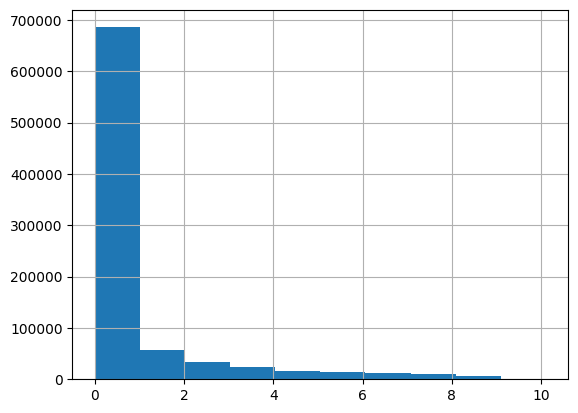

In [4]:
train = train[train["score"] > 0.005]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:05<00:00, 46.89it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7998


event   tolerance
onset   12           0.298598
        36           0.711727
        60           0.802454
        90           0.838482
        120          0.859800
        150          0.869297
        180          0.877390
        240          0.891356
        300          0.896381
        360          0.902006
wakeup  12           0.327101
        36           0.727184
        60           0.806527
        90           0.846501
        120          0.862953
        150          0.874463
        180          0.883992
        240          0.896828
        300          0.908085
        360          0.915410
dtype: float64